In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression

from bikesharing.params import *

In [2]:
X = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/introduce_weekday_features.csv').drop(columns='Unnamed: 0')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_holiday            35040 non-null  int64  
 1   is_weekend            35040 non-null  int64  
 2   temperature_2m        35040 non-null  float64
 3   apparent_temperature  35040 non-null  float64
 4   windspeed_10m         35040 non-null  float64
 5   precipitation         35040 non-null  float64
 6   hour_sin              35040 non-null  float64
 7   hour_cos              35040 non-null  float64
 8   month_sin             35040 non-null  float64
 9   month_cos             35040 non-null  float64
 10  day_sin               35040 non-null  float64
 11  day_cos               35040 non-null  float64
 12  weekday_sin           35040 non-null  float64
 13  weekday_cos           35040 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 3.7 MB


In [3]:
y = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/y_processed_from_2019_to_2022.csv')
y.head()

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
districts = y.columns

In [5]:
data = pd.concat([X,y] , axis=1)
data.shape

(35064, 48)

# Base XGBoost

In [6]:
fold_dfs = get_folds(data, fold_length=8760, fold_stride=8760)

In [86]:
models = []
districts_rmsle = []
districts_r2 = []

for dist in districts:
    scores_list = []
    scores_r2_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [round(x) if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        score_r2 = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
        
        scores_list.append(scores)
        scores_r2_list.append(score_r2)
    
    print(f"{id} >>> scores={scores_list}")
            
    scores_array = np.array(scores)
    districts_rmsle.append(np.mean(scores_array.flatten()))
    districts_r2.append(np.mean(scores_r2_list))

3 >>> scores=[0.7023357607948066, 0.712869222210316, 0.661162668952009, 0.6258777708554593]
3 >>> scores=[0.6554884072669888, 0.6155619381492289, 0.5664571070139415, 0.5701149740008048]
3 >>> scores=[0.44224740458754713, 0.4870033676744271, 0.3823783131520118, 0.3758636605407622]
3 >>> scores=[0.5419307545297766, 0.5295121768023021, 0.5233095486046623, 0.5366641772430637]
3 >>> scores=[0.5895498153070456, 0.5694633154217502, 0.5769641150090913, 0.57846611836802]
3 >>> scores=[0.17939652804115308, 0.2596919230062392, 0.11769439235563445, 0.12076314995208176]
3 >>> scores=[0.5071644604214892, 0.5097907140581667, 0.4735542684975069, 0.48978455803227355]
3 >>> scores=[0.34716700429833147, 0.35111346964499934, 0.3116968618947247, 0.32595941606315715]
3 >>> scores=[0.3120972880637239, 0.31453969665414017, 0.1698110252401612, 0.1617830337050749]
3 >>> scores=[0.5671834239729048, 0.5599328509440616, 0.5528565334588612, 0.5587765673272647]
3 >>> scores=[0.10036399976048134, 0.10111491048287977,

In [28]:
metrics_base = pd.DataFrame({'rmsle': districts_rmsle, 'r2': districts_r2}, index=districts).sort_values(by='rmsle', ascending=False)
metrics_base

,rmsle,r2
Altstadt-Lehel,0.377992,0.622795
Schwabing-Freimann,0.376678,0.618814
Milbertshofen-Am Hart,0.363782,0.455687
Ludwigsvorstadt-Isarvorstadt,0.355871,0.583185
Moosach,0.325163,0.303737
Maxvorstadt,0.324982,0.641605
Neuhausen-Nymphenburg,0.322129,0.584266
Sendling,0.321754,0.518934
Bogenhausen,0.317887,0.480502
Au - Haidhausen,0.312729,0.525842


In [87]:
metrics_round = pd.DataFrame({'rmsle': districts_rmsle, 'r2': districts_r2}, index=districts).sort_values(by='rmsle', ascending=False)
metrics_round

,rmsle,r2
Altstadt-Lehel,0.625878,0.621438
Schwabing-Freimann,0.623788,0.617277
Milbertshofen-Am Hart,0.615538,0.451414
Ludwigsvorstadt-Isarvorstadt,0.603305,0.581672
Moosach,0.585183,0.286916
Sendling,0.580899,0.511965
Bogenhausen,0.578466,0.470385
Neuhausen-Nymphenburg,0.576345,0.582493
Maxvorstadt,0.574280,0.640736
Au - Haidhausen,0.570115,0.519591


In [34]:
merged_metrics = metrics_base.merge(metrics_round, left_index=True, right_index=True, suffixes=('_base', '_round'))

In [37]:
merged_metrics

,rmsle_base,r2_base,rmsle_round,r2_round
Altstadt-Lehel,0.377992,0.622795,0.391723,0.621438
Schwabing-Freimann,0.376678,0.618814,0.389111,0.617277
Milbertshofen-Am Hart,0.363782,0.455687,0.378887,0.451414
Ludwigsvorstadt-Isarvorstadt,0.355871,0.583185,0.363977,0.581672
Moosach,0.325163,0.303737,0.342439,0.286916
Maxvorstadt,0.324982,0.641605,0.329797,0.640736
Neuhausen-Nymphenburg,0.322129,0.584266,0.332173,0.582493
Sendling,0.321754,0.518934,0.337443,0.511965
Bogenhausen,0.317887,0.480502,0.334623,0.470385
Au - Haidhausen,0.312729,0.525842,0.325031,0.519591


<Axes: >

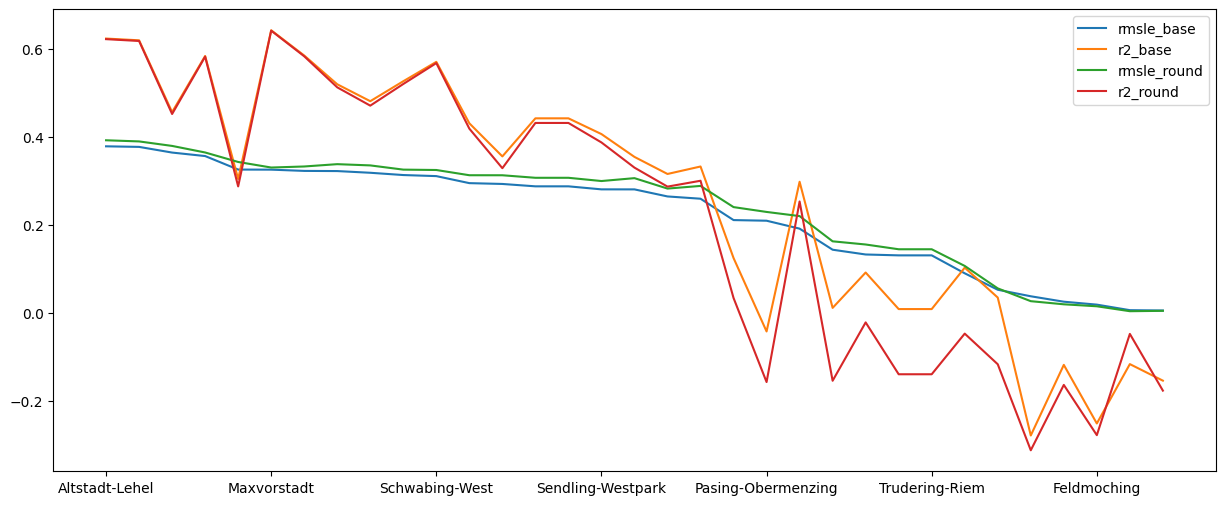

In [40]:
merged_metrics.drop('Aubing-Lochhausen-Langwied', axis=0).plot(figsize=(15,6))

In [37]:
xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

test_df = fold_dfs[3]
train_folds = [fold_dfs[i] for i in indices if i != 3]
        
train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns=districts)
y_test = test_df['Altstadt-Lehel']
X_train = train_df.drop(columns=districts)
y_train = train_df['Altstadt-Lehel']

xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)

Text(0.5, 1.0, 'y_pred')

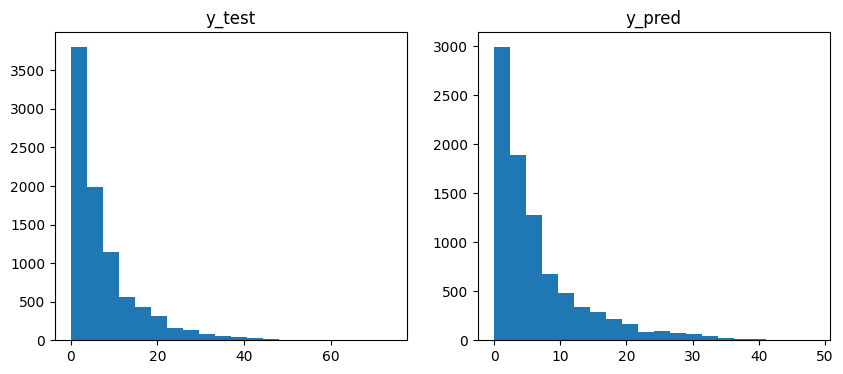

In [62]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y_test, bins=20)
ax[0].set_title('y_test')
ax[1].hist(y_pred, bins=20)
ax[1].set_title('y_pred')

list

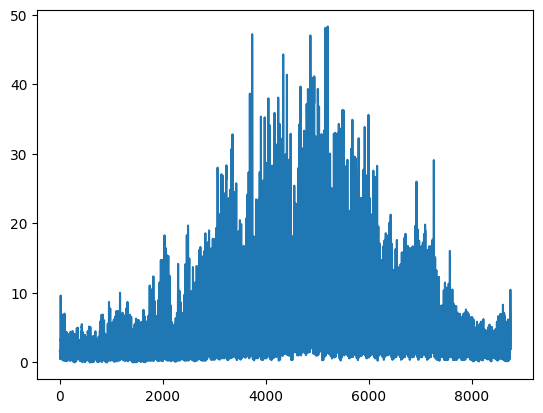

In [40]:
plt.plot(y_pred)

In [66]:
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
y_test_bins = est.fit_transform(pd.DataFrame(y_test))
y_pred_bins = est.transform(pd.DataFrame(y_pred))

/home/sandra/.pyenv/versions/3.10.6/envs/bike_sharing_demand/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


In [67]:
mean_squared_log_error(y_test_bins, y_pred_bins)

0.2158114378717189

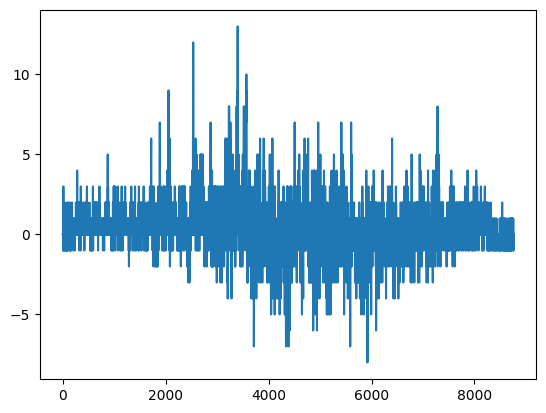

In [82]:
residuals = y_test_bins-y_pred_bins
plt.plot(residuals);

In [83]:
est.bin_edges_

array([array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ,
              40.7, 44.4, 48.1, 51.8, 55.5, 59.2, 62.9, 66.6, 70.3, 74. ])     ],
      dtype=object)

In [94]:
y.describe()

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,6.599390,3.466205,0.279432,1.171515,2.344484,0.055698,0.583077,0.216148,0.110541,1.556411,...,1.982090,3.101044,1.547313,0.123403,0.606063,0.323266,0.323266,1.808122,1.808122,0.019336
std,8.541564,3.959244,0.711903,1.600599,3.001915,0.293199,1.068778,0.570971,0.392132,1.979982,...,2.438443,3.909491,2.101708,0.390364,1.268230,0.755566,0.755566,2.480779,2.480779,0.156875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,9.000000,5.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,3.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000
max,75.000000,35.000000,10.000000,14.000000,39.000000,7.000000,15.000000,8.000000,9.000000,24.000000,...,23.000000,37.000000,18.000000,6.000000,26.000000,12.000000,12.000000,24.000000,24.000000,6.000000


In [96]:
pd.DataFrame(y.describe().loc['max'], index=districts).sort_values(by='max', ascending=False)

,max
Milbertshofen-Am Hart,121.0
Maxvorstadt,92.0
Schwabing-Freimann,81.0
Altstadt-Lehel,75.0
Ludwigsvorstadt-Isarvorstadt,72.0
Neuhausen-Nymphenburg,64.0
Schwabing-West,55.0
Bogenhausen,39.0
Sendling,37.0
Au - Haidhausen,35.0


In [98]:
r2_score(y_test, y_pred)

0.6084474886740192

In [99]:
X.head()

,is_holiday,is_weekend,temperature_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
0,1,0,0.355408,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1.0,0.356896
1,1,0,0.357616,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1.0,0.356896
2,1,0,0.359823,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1.0,0.356896
3,1,0,0.359823,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1.0,0.356896
4,1,0,0.359823,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1.0,0.356896


In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(y.T)

/home/sandra/.pyenv/versions/3.10.6/envs/bike_sharing_demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [113]:
pd.DataFrame({'labels':kmeans.labels_}, index=y.columns).sort_values(by='labels')

,labels
Untermenzing-Allach,0
Pasing,0
Pasing-Obermenzing,0
Ramersdorf-Perlach,0
Südgiesing,0
Lochhausen,0
Thalkirchen,0
Obersendling,0
Hasenbergl-Lerchenau Ost,0
Hadern,0


# Baseline Linear Regression

In [84]:
models = []
districts_rmsle = []
districts_r2 = []

for dist in districts:
    scores_list = []
    scores_r2_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        lr = LinearRegression()
        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        lr.fit(X_train, y_train)
        y_pred = [round(x) if x >= 0 else 0 for x in lr.predict(X_test)]
        score_r2 = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
        scores_list.append(scores)
        scores_r2_list.append(score_r2)
    
    print(f"{id} >>> scores={scores_list}")
            
    scores_array = np.array(scores)
    districts_rmsle.append(np.mean(scores_array.flatten()))
    districts_r2.append(np.mean(scores_r2_list))

3 >>> scores=[0.861463626444287, 0.9041058591686506, 0.8285730339306838, 0.7829551690196617]
3 >>> scores=[0.760930878796722, 0.7350329399917921, 0.6716913286346464, 0.6870136055327519]
3 >>> scores=[0.4373669933909828, 0.5041468253399972, 0.37795932467917076, 0.3968257682155859]
3 >>> scores=[0.5710197582963477, 0.569403596778994, 0.5650766504607992, 0.5685414282584471]
3 >>> scores=[0.659532780993634, 0.6558168430171659, 0.6486494327140949, 0.6687045424939325]
3 >>> scores=[0.17368937757010325, 0.2604123671164173, 0.10622389899901022, 0.09283048296124669]
3 >>> scores=[0.5281192355567751, 0.5335200804868325, 0.5040064303272825, 0.522955361429753]
3 >>> scores=[0.34595704425838636, 0.36076793511519006, 0.3109730507800928, 0.32552248887229934]
3 >>> scores=[0.31181891757435826, 0.3144112465111964, 0.1447914286770535, 0.12505663225356065]
3 >>> scores=[0.6152584727017055, 0.6031671679221013, 0.5972438865366811, 0.6087231615132517]
3 >>> scores=[0.09926503669500003, 0.09974965638854626, 

In [85]:
metrics_lr = pd.DataFrame({'rmsle': districts_rmsle, 'r2': districts_r2}, index=districts).sort_values(by='rmsle', ascending=False)

In [88]:
metrics_lr_xgb = metrics_round.merge(metrics_lr, left_index=True, right_index=True, suffixes=('_xgb', '_lr'))
metrics_lr_xgb

,rmsle_xgb,r2_xgb,rmsle_lr,r2_lr
Altstadt-Lehel,0.625878,0.621438,0.782955,0.497068
Schwabing-Freimann,0.623788,0.617277,0.813007,0.483029
Milbertshofen-Am Hart,0.615538,0.451414,0.730840,0.382946
Ludwigsvorstadt-Isarvorstadt,0.603305,0.581672,0.764469,0.433136
Moosach,0.585183,0.286916,0.663895,0.217877
Sendling,0.580899,0.511965,0.685410,0.375419
Bogenhausen,0.578466,0.470385,0.668705,0.352667
Neuhausen-Nymphenburg,0.576345,0.582493,0.737452,0.419340
Maxvorstadt,0.574280,0.640736,0.792187,0.505190
Au - Haidhausen,0.570115,0.519591,0.687014,0.393650


In [90]:
metrics_lr_xgb.to_csv(os.path.join(os.path.expanduser('~'), ".lewagon", "bikesharing", "results", "metrics_xgb_vs_lr.csv"), index=True)

<Axes: >

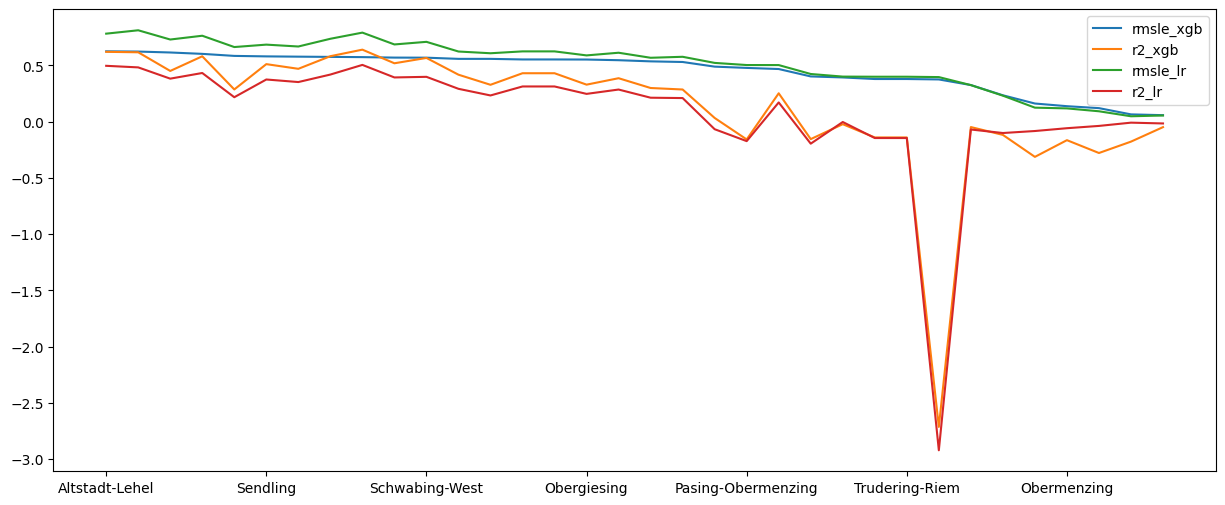

In [89]:
metrics_lr_xgb.plot(figsize=(15,6))

# GridSearch Altstadt

In [59]:
# get folds of 12 months
fold_dfs = get_folds(data, fold_length=8760, fold_stride=8760)

In [69]:
# get X_train & X_test
test_df = fold_dfs[3]    
val_df = fold_dfs[2]   
train_df = pd.concat(fold_dfs[0:3], axis=0)

X_test = test_df.drop(columns=districts)
y_test = test_df['Altstadt-Lehel']
X_val = val_df.drop(columns=districts)
y_val = val_df['Altstadt-Lehel']
X_train = train_df.drop(columns=districts)
y_train = train_df['Altstadt-Lehel']

In [70]:
X_test.shape, y_test.shape, X_val.shape, y_val.shape, X_train.shape, y_train.shape

((8760, 14), (8760,), (8760, 14), (8760,), (26280, 14), (26280,))

In [92]:
np.arange(0.01,0.2, 0.03)

array([0.01, 0.04, 0.07, 0.1 , 0.13, 0.16, 0.19])

In [65]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Instantiate model
model = XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)

# Hyperparameter Grid
grid = {
    'n_estimators': , 
    'seed': ,
    'eta': [0.01, 0.03, 0.7, 0.1, 0.15, 0.2], 
    'gamma': 
}

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
ps = PredefinedSplit(test_fold=split_index)

# Instantiate Grid Search
search = GridSearchCV(
    model,
    grid, 
    scoring = 'neg_mean_squared_log_error',
    cv = ps,
    n_jobs=-1 # parallelize computation
) 

# Fit data to Grid Search
search.fit(X_train, y_train);


ValueError: Found input variables with inconsistent numbers of samples: [35040, 35064]